In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os
for dirname, _, filenames in os.walk("/voice.csv"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

plt.style.use("seaborn-dark")
np.random.seed(42)

In [ ]:
data = pd.read_csv('/content/voice.csv')
data.head()

In [ ]:
data.shape

(3168, 21)

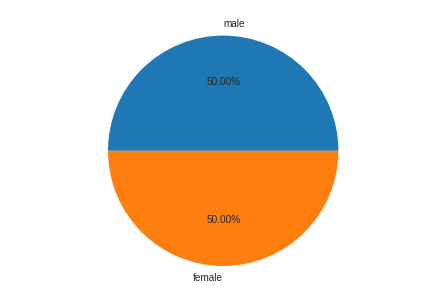

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

labels = data['label'].unique()
target = data['label'].value_counts()
ax.pie(target, labels = labels,autopct='%1.2f%%')
plt.show()

In [ ]:
data.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [ ]:
def draw_corr(features):
    #Init
    corr_matrix = data[features].corr()
    tol = 0.7

    # correlation diagram creation
    def corr_tol(x):
        return x.apply(lambda x : True if (x >= tol or x <= -tol) else False)
    bool_corr_matrix = corr_matrix.apply(lambda x : corr_tol(x))

    for i in range(0,len(bool_corr_matrix)):
        bool_corr_matrix.iloc[i,i] = False

    bool_corr_matrix = pd.DataFrame(np.tril(bool_corr_matrix, k=0),
                                    columns=bool_corr_matrix.columns, index=bool_corr_matrix.index)

    plt.figure(figsize=(10,5))
    plt.grid(True)
    sns_plot = sns.heatmap(bool_corr_matrix, square=True, cmap=sns.cubehelix_palette(8), linewidths=0.1)
    sns_plot.set_ylim(len(bool_corr_matrix)-1, -1)
    plt.show()

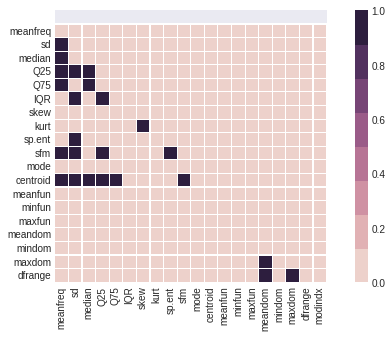

In [ ]:
draw_corr(data.columns)

In [ ]:
# Automatic field selection

corr_matrix = data.corr()

columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False

selected_columns = data.drop('label', axis=1).columns[columns]
selected_columns

Index(['meanfreq', 'sd', 'Q75', 'skew', 'sp.ent', 'mode', 'meanfun', 'minfun',
       'maxfun', 'meandom', 'mindom', 'modindx'],
      dtype='object')

In [ ]:
features = ['meanfreq', 'skew', 'sp.ent', 'mode', 'meanfun', 'minfun',
       'maxfun', 'meandom', 'mindom', 'modindx']

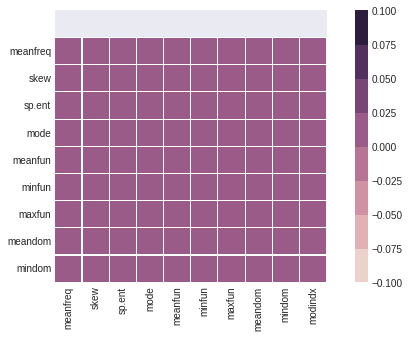

In [ ]:
draw_corr(features)


In [ ]:
X = data.loc[:, data.columns!='label']
y = data['label']

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(le.classes_)

['female' 'male']


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   stratify = y,
                                                   test_size = 0.20)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
lda_trans_df = lda.fit_transform(X_train, y_train)
X_train = pd.DataFrame(lda_trans_df)

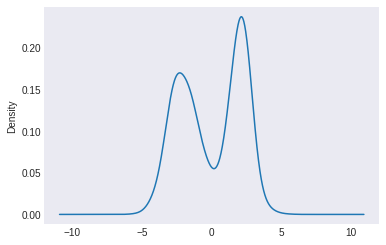

In [ ]:
pd.DataFrame(X_train).plot.kde()
plt.legend("")

In [ ]:
from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier
clf = SVC()
#clf=RandomForestClassifier()
#Init
model_for_cv = clf

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_for_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.01)


In [ ]:
from lightgbm import LGBMClassifier #accuracy-97%
#from sklearn.ensemble import GradientBoostingClassifier #accuracy-96%
#clf=RandomForestClassifier() #accuracy-95%
#clf = GradientBoostingClassifier()
clf=LGBMClassifier()

model_for_cv = clf

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_for_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.01)


In [ ]:
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeRegressor
model = LogisticRegression()
#model=DecisionTreeRegressor(random_state = 0)
model_for_cv = model

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_for_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.01)


In [ ]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
X_test = lda.transform(scaler.transform(X_test))
y_pred = clf.predict(X_test)

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('-----------------------------')
print("----Classification Report----")
print('-----------------------------')
print(classification_report(y_test, y_pred))

[[309   8]
 [  6 311]]
-----------------------------
----Classification Report----
-----------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       317
           1       0.97      0.98      0.98       317

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



In [ ]:
from google.colab import drive
drive.mount('/content/drive')